In [4]:
!pip install tensorflow-gpu==2.7.0 opencv-python tensorflow_datasets matplotlib pycocotools numpy;

^C


In [17]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import cv2
import os
import tensorflow_datasets as tfds
import datetime
from coco import COCO
from coco_labels_paper import labels as coco_labels
import shutil
from tensorflow.keras.utils import to_categorical
import matplotlib as plt
from tensorflow import keras
from keras import backend as K
import random

In [2]:
TRAIN_IMAGES = 'data/coco_onehot_train'
VAL_IMAGES = 'data/coco_onehot_val'

In [2]:
resnet50 = keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))
resnet50.summary()
resnet50.trainable = True

2022-03-28 07:01:18.767511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 07:01:18.772883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 07:01:18.773001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 07:01:18.773293: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

94781440/94765736 [==============================] - 4s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [3]:
#LAMBDA FUNCTIONS CANNOT BE LOADED!!
def distance_layer(vectors):
    (features_A, features_B) = vectors
    sum_squared = K.sum(K.square(features_A - features_B), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))


class DistanceLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__()
       
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [4]:
input_a = Input(shape=(224,224,3))
input_b = Input(shape=(224,224,3))

features_a = resnet50(input_a)
features_b = resnet50(input_b)

#distance = Lambda(distance_layer)([features_a, features_b])
siamese = DistanceLayer()
distance = siamese(features_a, features_b)
distance = MaxPool2D(5)(distance)
distance = Flatten()(distance)
distance = Dense(1024, activation="relu")(distance)
distance = Dense(1024, activation="relu")(distance)
output = Dense(1, activation="sigmoid")(distance)
siamese_model = Model(inputs=[input_a, input_b], outputs=output)

siamese_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['input_2[0][0]',                
                                                                  'input_3[0][0]']            

In [23]:
train_files = {}
for d in os.listdir(TRAIN_IMAGES):
    files = os.listdir(f"{TRAIN_IMAGES}/{d}")
    if len(files) > 0:
        train_files[d] = files

print(len(train_files))

val_files = {}
for d in os.listdir(VAL_IMAGES):
    files = os.listdir(f"{VAL_IMAGES}/{d}")
    if len(files) > 0:
        val_files[d] = files

print(len(val_files))

80
70


In [19]:
def get_training_data(epoch_size=1024, training: bool=True):
    X_a = []
    X_b = []
    Y = []

    image_set = train_files if training else val_files
    image_dir = TRAIN_IMAGES if training else VAL_IMAGES

    available_classes = list(image_set.keys())

    for i in range(int(epoch_size/2)):

        c = random.choice(available_classes)
        n = random.choice([d for d in available_classes if d is not c])
        anchor = random.choice(image_set[c])
        positive = random.choice(image_set[c])
        negative = random.choice(image_set[n])

        X_a.append(f"{image_dir}/{c}/{anchor}")
        X_a.append(f"{image_dir}/{c}/{anchor}")
        X_b.append(f"{image_dir}/{c}/{positive}")
        X_b.append(f"{image_dir}/{n}/{negative}")
        Y.append(1)
        Y.append(0)

    return (X_a, X_b, Y)

def get_training_dataset(epoch_size=1024, training: bool=True):
    data = get_training_data(epoch_size, training)
    a = tf.data.Dataset.from_tensor_slices(data[0])
    b = tf.data.Dataset.from_tensor_slices(data[1])
    y = tf.data.Dataset.from_tensor_slices(data[2])
    final_data = tf.data.Dataset.zip((a,b,y))
    processed_data = final_data.map(preprocess_twins)
    return processed_data


In [21]:
def load_images(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224,224))
    img = img/255.0
    return img

def preprocess_twins(anchor, validation, label):
    return ((load_images(anchor), load_images(validation)), label)

In [8]:
dasd = get_training_data()
# random.choice(os.listdir("data/coco_onehot_data/airplane"))
print(len(dasd[0]))

1024


In [20]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)
siamese_model.compile(loss=binary_cross_loss, optimizer=opt, metrics=METRICS)

2022-04-17 10:35:19.288282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 10:35:19.294143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 10:35:19.294277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 10:35:19.294864: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

NameError: name 'siamese_model' is not defined

In [9]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs/siamese

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/siamese/{0}'.format(current_time)
weight_dir = 'weights/siamese/{0}'.format(current_time)

summary_writer = tf.summary.create_file_writer(log_dir)
summary_writer.set_as_default()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, update_freq=100)

In [10]:
for e in range(1):
    train_data = get_training_dataset(4096*64)
    train_data = train_data.batch(32)
    train_data = train_data.prefetch(32)

    val_data = get_training_dataset(4096)
    val_data = val_data.batch(32)
    val_data = val_data.prefetch(32)

    #print(len(data[2]))
    loss = siamese_model.fit(train_data, batch_size=32, epochs=20, validation_data=val_data, callbacks=[tensorboard_callback])
    print(loss)

Epoch 1/20


2022-03-28 07:03:33.871267: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-03-28 07:03:34.536564: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-28 07:03:35.838559: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


8192/8192 [==============================] - 3163s 385ms/step - loss: 0.5336 - tp: 97847.0000 - fp: 38065.0000 - tn: 93007.0000 - fn: 33225.0000 - accuracy: 0.7281 - precision: 0.7199 - recall: 0.7465 - auc: 0.8077 - prc: 0.7910 - val_loss: 0.4619 - val_tp: 1661.0000 - val_fp: 483.0000 - val_tn: 1565.0000 - val_fn: 387.0000 - val_accuracy: 0.7876 - val_precision: 0.7747 - val_recall: 0.8110 - val_auc: 0.8656 - val_prc: 0.8528
Epoch 2/20
8192/8192 [==============================] - 3139s 383ms/step - loss: 0.4249 - tp: 107626.0000 - fp: 28741.0000 - tn: 102331.0000 - fn: 23446.0000 - accuracy: 0.8009 - precision: 0.7892 - recall: 0.8211 - auc: 0.8838 - prc: 0.8741 - val_loss: 0.4097 - val_tp: 1777.0000 - val_fp: 478.0000 - val_tn: 1570.0000 - val_fn: 271.0000 - val_accuracy: 0.8171 - val_precision: 0.7880 - val_recall: 0.8677 - val_auc: 0.8978 - val_prc: 0.8881
Epoch 3/20
 539/8192 [>.............................] - ETA: 48:26 - loss: 0.3788 - tp: 7297.0000 - fp: 1644.0000 - tn: 6980.00

KeyboardInterrupt: 

In [3]:
#siamese_model.save_weights(os.path.join("weights/siamese_pretrained", "model"))
siamese_model.save(os.path.join("weights/siamese_pretrained", "siamesev3"),)
#siamese_model = tf.keras.models.load_model(os.path.join("weights/siamese_pretrained", "siamesev3"))

2022-03-28 23:03:43.205325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 23:03:43.218936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 23:03:43.219120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 23:03:43.219748: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

tf.Tensor([1 0], shape=(2,), dtype=int32)


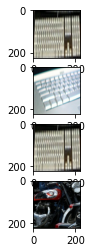

In [30]:
data = get_training_data(2, False)
a = tf.data.Dataset.from_tensor_slices(data[0])
b = tf.data.Dataset.from_tensor_slices(data[1])
y = tf.data.Dataset.from_tensor_slices(data[2])
final_data = tf.data.Dataset.zip((a,b,y))
processed_data = final_data.map(preprocess_twins)
processed_data = processed_data.batch(2)
processed_data = processed_data.prefetch(2)

img_batch = next(iter(processed_data))

#plt.pyplot.imshow(img_batch[0][0][0])
fig, axs = plt.pyplot.subplots(4,1)
axs[0].imshow(img_batch[0][0][0])
axs[1].imshow(img_batch[0][1][0])

axs[2].imshow(img_batch[0][0][1])
axs[3].imshow(img_batch[0][1][1])
print(img_batch[1])

In [31]:
siamese_model.predict(img_batch[0])

array([[0.9382267 ],
       [0.02013198]], dtype=float32)

In [24]:
siamese_model = tf.keras.models.load_model(os.path.join("weights/siamese_pretrained", "siamesev3"))
test_data = get_training_dataset(36000, False)
test_data = test_data.batch(32)
test_data = test_data.prefetch(32)
siamese_model.evaluate(test_data)

2022-04-17 10:37:18.651752: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-04-17 10:37:19.128034: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


   2/1125 [..............................] - ETA: 2:50 - loss: 0.3539 - tp: 31.0000 - fp: 9.0000 - tn: 23.0000 - fn: 1.0000 - accuracy: 0.8438 - precision: 0.7750 - recall: 0.9688 - auc: 0.9082 - prc: 0.9032   

2022-04-17 10:37:20.799596: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1125/1125 [==============================] - 174s 151ms/step - loss: 0.3996 - tp: 16068.0000 - fp: 4119.0000 - tn: 13881.0000 - fn: 1932.0000 - accuracy: 0.8319 - precision: 0.7960 - recall: 0.8927 - auc: 0.8954 - prc: 0.8771


[0.3995676636695862,
 16068.0,
 4119.0,
 13881.0,
 1932.0,
 0.8319166898727417,
 0.7959578037261963,
 0.8926666378974915,
 0.8954139351844788,
 0.8771495819091797]

In [4]:
#save anchors for predictions later
import shutil

MAX_ANCHORS = 5

for dir in os.listdir(TRAIN_IMAGES):
    count = 0
    for file in os.listdir(os.path.join(TRAIN_IMAGES, dir)):
        c = dir

        if not os.path.exists(f'data/siamese_anchors/{c}'):
            os.mkdir(f'data/siamese_anchors/{c}')

        shutil.copyfile(os.path.join(TRAIN_IMAGES, dir, file), f'data/siamese_anchors/{c}/{file}')
        count += 1

        print(count)

        if count >= MAX_ANCHORS:
            break

# for subdir, dirs, files in os.walk(TRAIN_IMAGES):
#     for file in files:
#         c = subdir.split("/")[-1]
#         if not os.path.exists(f'data/siamese_anchors/{c}'):
#             os.mkdir(f'data/siamese_anchors/{c}')
#         shutil.copyfile(os.path.join(subdir, file), f'data/siamese_anchors/{c}/{file}')
#         count += 1

#         if count > MAX_ANCHORS:
#             break

1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
